# Heart Attack Analysis and Prediction

## Question:
> Can we predict whether a patient is at risk of a heart attack based on symptoms and physical traits with an accuracy of 85% or greater?

### Column Information:
Age : Age of the patient

Sex : Sex of the patient

exang: exercise induced angina (1 = yes; 0 = no)

ca: number of major vessels (0-3)

cp : Chest Pain type chest pain type

Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4: asymptomatic
trtbps : resting blood pressure (in mm Hg)

chol : cholestoral in mg/dl fetched via BMI sensor

fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

rest_ecg : resting electrocardiographic results

Value 0: normal
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach : maximum heart rate achieved

target : 0= less chance of heart attack 1= more chance of heart attack

### Packages/Imports

In [140]:
# Data Analysis
import pandas as pd # Data processing, CSV files
import numpy as np # Linear Algebra
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error

import warnings

warnings.filterwarnings("ignore")

### Analysis

In [143]:
# Load in the heart dataset
heart = pd.read_csv('heart.csv')

In [145]:
# Quick overview of the structure of the dataframe
heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [147]:
# Find the number of columns and rows in the dataframe
print("Number of rows in the DF are", heart.shape[0])
print("Number of columns in the DF are", heart.shape[1])

Number of rows in the DF are 303
Number of columns in the DF are 14


In [149]:
# Check datatypes of each class in the DF
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [151]:
# Check the data for any null values
heart.isnull().sum()/len(heart)*100

age         0.0
sex         0.0
cp          0.0
trtbps      0.0
chol        0.0
fbs         0.0
restecg     0.0
thalachh    0.0
exng        0.0
oldpeak     0.0
slp         0.0
caa         0.0
thall       0.0
output      0.0
dtype: float64

In [153]:
# Check for any duplicate values
heart[heart.duplicated()]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [155]:
# Remove any duplicate values
heart.drop_duplicates(keep='first', inplace=True)

In [157]:
# Re-check the shape of the dataframe to ensure duplicate value was removed.
print("Number of rows in the DF are", heart.shape[0])
print("Number of columns in the DF are", heart.shape[1])

Number of rows in the DF are 302
Number of columns in the DF are 14


In [161]:
# Statistics of the dataframe
heart.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [165]:
# Compute the correlation matrix for the dataframe
heart.corr()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,-0.094962,-0.063107,0.283121,0.207216,0.119492,-0.111590,-0.395235,0.093216,0.206040,-0.164124,0.302261,0.065317,-0.221476
sex,-0.094962,1.000000,-0.051740,-0.057647,-0.195571,0.046022,-0.060351,-0.046439,0.143460,0.098322,-0.032990,0.113060,0.211452,-0.283609
cp,-0.063107,-0.051740,1.000000,0.046486,-0.072682,0.096018,0.041561,0.293367,-0.392937,-0.146692,0.116854,-0.195356,-0.160370,0.432080
trtbps,0.283121,-0.057647,0.046486,1.000000,0.125256,0.178125,-0.115367,-0.048023,0.068526,0.194600,-0.122873,0.099248,0.062870,-0.146269
chol,0.207216,-0.195571,-0.072682,0.125256,1.000000,0.011428,-0.147602,-0.005308,0.064099,0.050086,0.000417,0.086878,0.096810,-0.081437
fbs,0.119492,0.046022,0.096018,0.178125,0.011428,1.000000,-0.083081,-0.007169,0.024729,0.004514,-0.058654,0.144935,-0.032752,-0.026826
restecg,-0.111590,-0.060351,0.041561,-0.115367,-0.147602,-0.083081,1.000000,0.041210,-0.068807,-0.056251,0.090402,-0.083112,-0.010473,0.134874
thalachh,-0.395235,-0.046439,0.293367,-0.048023,-0.005308,-0.007169,0.041210,1.000000,-0.377411,-0.342201,0.384754,-0.228311,-0.094910,0.419955
exng,0.093216,0.143460,-0.392937,0.068526,0.064099,0.024729,-0.068807,-0.377411,1.000000,0.286766,-0.256106,0.125377,0.205826,-0.435601
oldpeak,0.206040,0.098322,-0.146692,0.194600,0.050086,0.004514,-0.056251,-0.342201,0.286766,1.000000,-0.576314,0.236560,0.209090,-0.429146


### Visualize the Data

To start, I will create visuals for singular variables to see the distribution of their values.

Number of people as sex 1 are 206
Number of people as sex 0 are 96


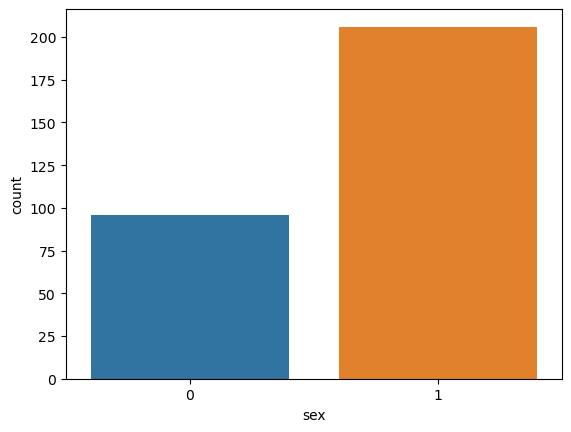

In [169]:
# Visual displaying the difference between genders
gender = (heart.sex.value_counts())
print(f"Number of people as sex 1 are {gender[1]}")
print(f"Number of people as sex 0 are {gender[0]}")
plot = sns.countplot(data=heart, x='sex')
plt.show()

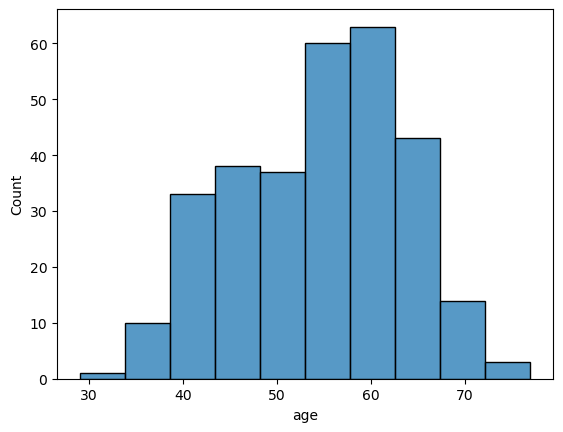

In [171]:
# Show the frequency of each age
sns.histplot(data=heart, x='age', kde=False, bins=10);

Value 0 = 143: typical angina
Value 1 = 50: atypical angina
Value 2 = 86: non-anginal pain
Value 3 = 23: asymptomatic


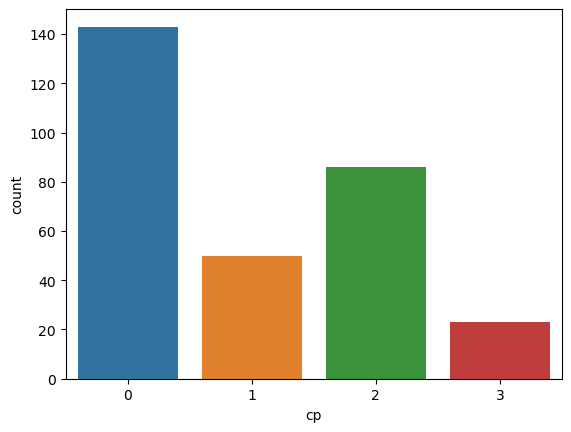

In [173]:
# Visualize the chest pain category (cp)
cp = (heart.cp.value_counts())
print(f"Value 0 = {cp[0]}: typical angina")
print(f"Value 1 = {cp[1]}: atypical angina")
print(f"Value 2 = {cp[2]}: non-anginal pain")
print(f"Value 3 = {cp[3]}: asymptomatic")
sns.countplot(data=heart, x='cp');

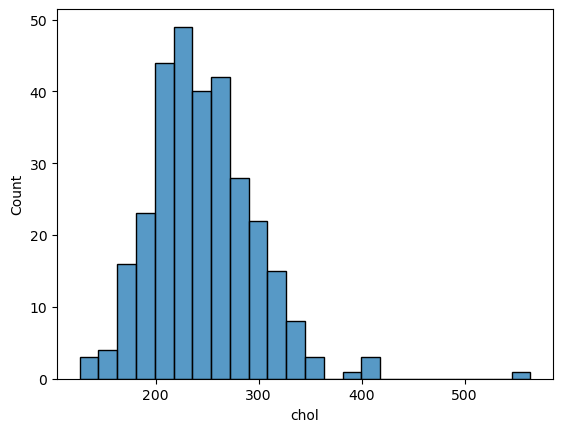

In [175]:
# Show the frequency of cholesterol levels among patients
sns.histplot(data=heart, x='chol');

fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
fbs
0    257
1     45
Name: count, dtype: int64


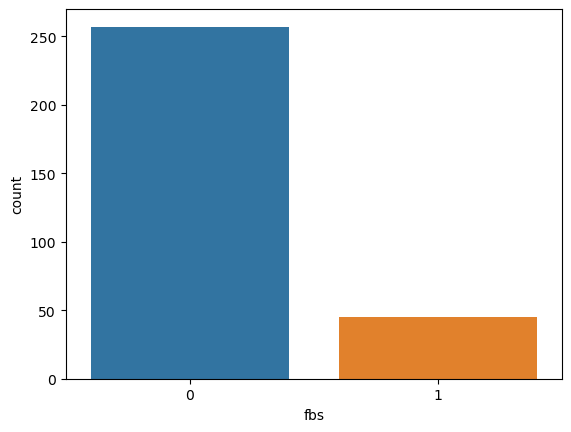

In [177]:
# Visualize the fast blood sugar counts
fbs = (heart.fbs.value_counts())
print("fasting blood sugar > 120 mg/dl (1 = true; 0 = false)")
print(fbs)
sns.countplot(data=heart, x='fbs');

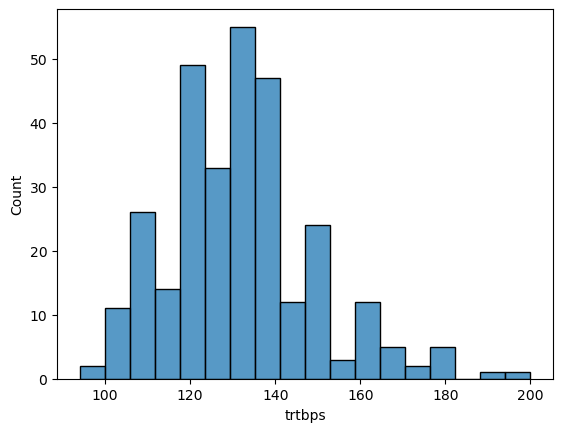

In [179]:
# Visualize the resting blood pressure column 'trtbps'
sns.histplot(data=heart, x='trtbps');

With these intial visuals, I can see that the "1" sex, presummably males, is far more common, which through well known data is not surprising. The most common range is 50-65, having more than 100 individuals fall in that range. 23 individuals reported having asymptomatic levels of chest pain and the most common resting blood pressure is around 130-140bps. Most fasting blood sugar levels fall below the 120 mg/dl level with roughly 50 being greater. 

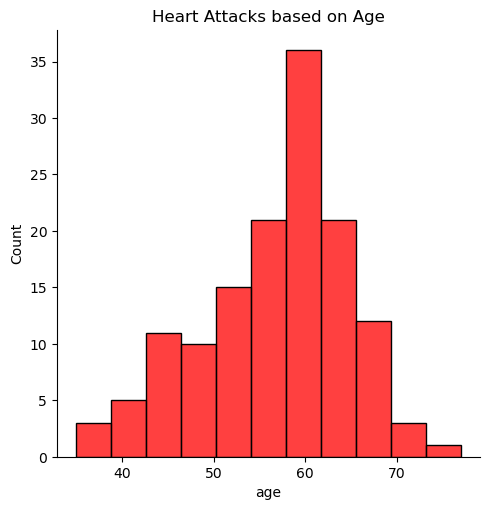

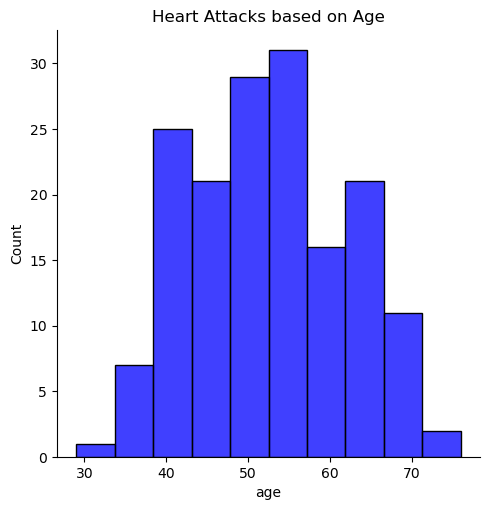

In [182]:
# Compare age with heart attack outcome 'output'
sns.displot(heart[heart["output"] == 0]['age'], color='red');
plt.title("Heart Attacks based on Age")
sns.displot(heart[heart['output'] == 1]['age'], color='blue');
plt.title("Heart Attacks based on Age")
plt.show()

Here we can see that the age range with the higest risk of heart attack tends to be between 38-57 with a slight drop around age 45. Suprisingly age 60 has the highest count of individuals with less chance of a heart attack, which contradicts my original belief.

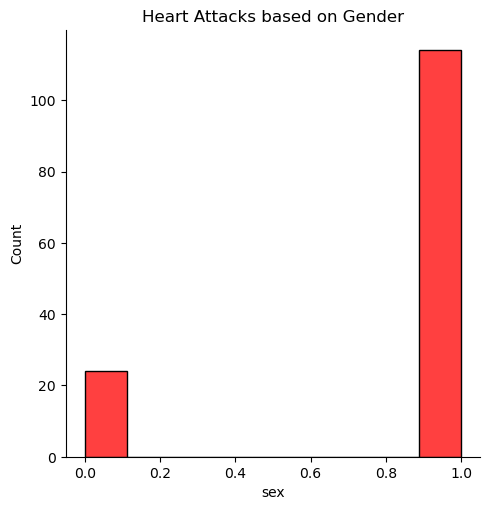

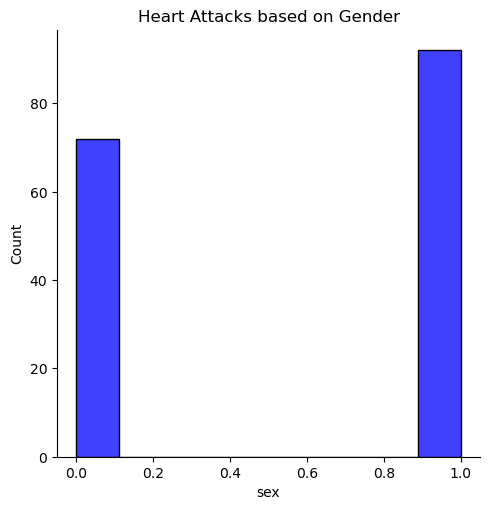

In [185]:
# Compare the output column with the sex column
sns.displot(heart[heart["output"] == 0]['sex'], color='red');
plt.title("Heart Attacks based on Gender")
sns.displot(heart[heart['output'] == 1]['sex'], color='blue');
plt.title("Heart Attacks based on Gender")
plt.show()

As expected, the gender labeled '1' which I am to assume is male, has the highest count of both less chance and high chance of heart attack. This data is more than likely skewed due to the abundance of gender 1.

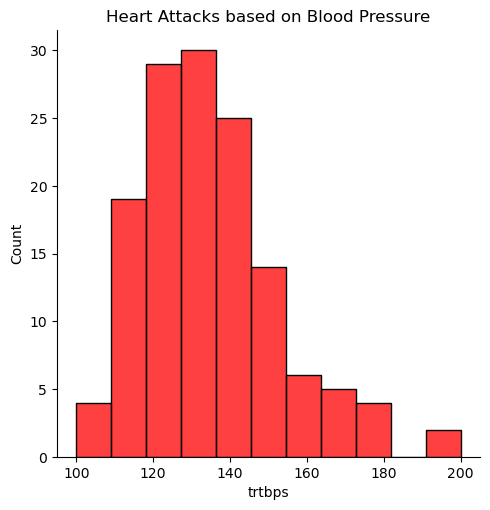

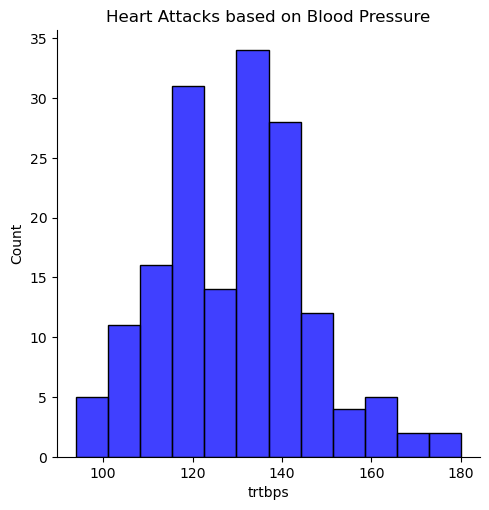

In [188]:
# Compare resting blood pressure with output
sns.displot(heart[heart["output"] == 0]['trtbps'], color='red');
plt.title("Heart Attacks based on Blood Pressure")
sns.displot(heart[heart['output'] == 1]['trtbps'], color='blue');
plt.title("Heart Attacks based on Blood Pressure")
plt.show()

With these visuals I can see that individuals with blood pressue values around the 130 to 140 range tend to have a slightly higher chance of heart attack as compared to less chance. That being said, I don't see blood pressure being a strong enough feature to make accurate predictions on without complimenting data.

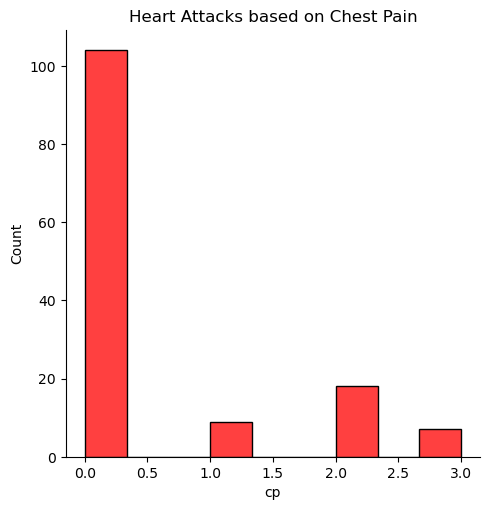

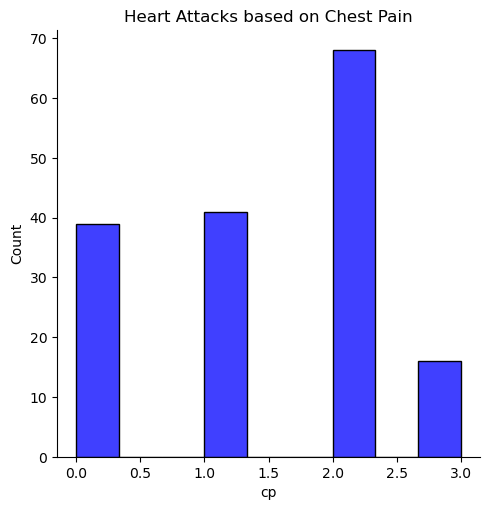

In [191]:
# Compare chest pain with output
sns.displot(heart[heart["output"] == 0]['cp'], color='red');
plt.title("Heart Attacks based on Chest Pain")
sns.displot(heart[heart['output'] == 1]['cp'], color='blue');
plt.title("Heart Attacks based on Chest Pain")
plt.show()

With chest pain being a more common sign of heart attack, these visuals show which level of chest pain correlates to being at a higher risk of HA. Level 2, or non-anginal pain, seems to be the most indicative of a high risk of heart attack, with roughly 70 counts of individuals being at risk. Level 0 indicates a low risk of heart attack more often than not.

## Split Data into Testing and Training Sets

In [195]:
# Declare X and y variables
X = heart.drop('output', axis=1)
y = heart['output']

In [197]:
# Split data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [199]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(241, 13)
(61, 13)
(241,)
(61,)


In [201]:
# Initialize the StandardScaler
scaler = StandardScaler()

X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

### Models

In [206]:
# Initialize the classifier models,
# Create a results dictionary to store the results
# Use a for loop to iterate through fitting each model and generating predictions
# Output the results in a viewable dataframe 
models = {
    'SVC': SVC(),
    'RF': RandomForestClassifier(),
    'DT': DecisionTreeClassifier(),
    'KN': KNeighborsClassifier(),
    'XGB': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

result = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_preds = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    sensitivity = recall_score(y_test, y_preds)
    mse = mean_squared_error(y_test, y_preds)

    result[name] = {
            'Accuracy': accuracy,
            'F1': f1,
            'Precision': precision,
            'Sensitivity': sensitivity,
            'MSE': mse
    }

result_df = pd.DataFrame(result).T

result_df

,Accuracy,F1,Precision,Sensitivity,MSE
SVC,0.803279,0.823529,0.777778,0.87500,0.196721
RF,0.868852,0.875000,0.875000,0.87500,0.131148
DT,0.786885,0.786885,0.827586,0.75000,0.213115
KN,0.885246,0.888889,0.903226,0.87500,0.114754
XGB,0.688525,0.765432,0.632653,0.96875,0.311475


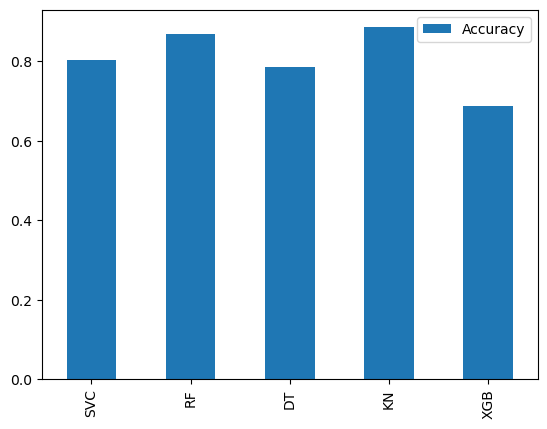

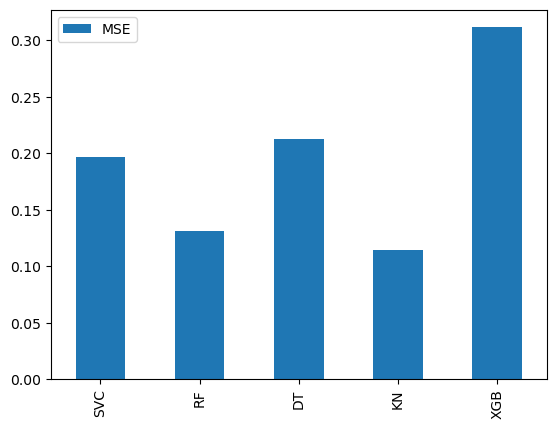

In [208]:
result_df.plot(kind='bar', y='Accuracy');

result_df.plot(kind='bar', y='MSE');

### Findings

After comparing multiple models, the one with the best overall metrics was KNeighbors. This model produced an accuracy of 88.5% an F1 score of 88.8%, a precision of 90.3%, and a sensitivity of 87.5%. This model is only a slight improvement over the RandomForest which is roughly 3% behind in accuracy. The KNeighbors model does indicate that we can in fact predict a patient's risk of heart attack at a fairly high level of accuracy.

### Lets Try SMOTEENN

Use SMOTEENN's class balancing to re-evaluate the effectiveness of the models.

In [210]:
smoteenn = SMOTEENN()
X_new, y_new = smoteenn.fit_resample(X,y)

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

In [214]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [216]:
models = {
    'SVC': SVC(),
    'RF': RandomForestClassifier(),
    'DT': DecisionTreeClassifier(),
    'KN': KNeighborsClassifier(),
    'XGB': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

result = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_preds = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    sensitivity = recall_score(y_test, y_preds)
    mse = mean_squared_error(y_test, y_preds)

    result[name] = {
            'Accuracy': accuracy,
            'F1': f1,
            'Precision': precision,
            'Sensitivity': sensitivity,
            'MSE': mse
    }

result_df = pd.DataFrame(result).T

result_df

,Accuracy,F1,Precision,Sensitivity,MSE
SVC,0.944444,0.923077,0.857143,1.0,0.055556
RF,0.944444,0.923077,0.857143,1.0,0.055556
DT,0.944444,0.923077,0.857143,1.0,0.055556
KN,0.888889,0.857143,0.750000,1.0,0.111111
XGB,0.944444,0.923077,0.857143,1.0,0.055556


In [ ]:
result_df.plot(kind='bar', y='Accuracy');

result_df.plot(kind='bar', y='MSE');

After implementing SMOTEENN to aid in balancing the dataset features, the accuracy of each model increased! Each model is now at minimum 90% accurate, with 3 models being 95% accurate. This indicates an overall success of the models. XGBoost fell below my expectations as it is known for having a high level of accuracy, but due to my limited knowledge of its hyperparameter tuning it came in at 90%. I am sure that with proper parameter tuning it could exceed the other models in performance.